In [1]:
# import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2
import math
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20*1.5, 12*1.5

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo

In [2]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.gca().invert_yaxis()
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        print("score", score)
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[part, :, :]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        #peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     #np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks_binary = (sigmoid_v(map_ori) > .2)
        #print("pb shap", np.shape(peaks_binary))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks



In [3]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'jet',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    #'text.usetex': True,
    'figure.figsize': [20, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [4]:
def overlay_keypoints(image, predictions):
        #keypoints = predictions.get_field("keypoints")
        kps = predictions#keypoints.keypoints
        scores = kps.new_ones((kps.size(0), kps.size(1)))
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            kfun = BeeKeypoints
            image = vis_keypoints_others(
                    image,
                    region.transpose((1, 0)),
                    kp_thresh=0,
                    kfun=kfun)
                
        return image


In [5]:
import cv2
import torch
from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints, BeeKeypoints, FlyKeypoints


def vis_keypoints_others(img, kps, kp_thresh=2, alpha=0.7, kfun=PersonKeypoints):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    img = img.copy()
    dataset_keypoints = kfun.NAMES
    kp_lines = kfun.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)
    
    # Draw the keypoints.
    for l in [0]:#range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        #if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
         #   cv2.line(
          #      kp_mask, p1, p2,
           #     color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        #if kps[2, i2] > kp_thresh:
         #   cv2.circle(
          #      kp_mask, p2,
           #     radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

def get_centroid(coord):
    return [(coord[0]+coord[2])/2, (coord[1]+coord[3])/2]

def get_dist(p1, p2):
    dist = math.hypot(p2[0] - p1[0], p2[1] - p1[1])
    return dist


In [6]:
#test_file = 'bee_test.png'
#image = load(test_file)
base = "../tools/datasets/bee/validation/"
#base = "../tools/datasets/bee/train/"
base_val = "../tools/datasets/bee/annotations/validation.json"
#base_val = "../tools/datasets/bee/annotations/train_bee_annotations2018_nondup.json"

import json
with open(base_val) as f:
    data_an = json.load(f)
#print(data_an["annotations"][0])

test_files = []
for p in data_an['images'][:]:
    test_files.append(str(p['file_name']))

print(test_files)
print(len(test_files))
test_images = []
for file in test_files:
    test_images.append(load(base + file))



['000000051501.jpg', '000000051602.jpg', '000000051656.jpg', '000000051770.jpg', '000000052209.jpg', '000000052239.jpg', '000000052248.jpg', '000000052271.jpg', '000000052328.jpg', '000000052361.jpg', '000000052413.jpg', '000000052563.jpg', '000000052583.jpg', '000000052587.jpg', '000000052738.jpg', '000000052799.jpg', '000000052861.jpg', '000000053184.jpg', '000000053247.jpg', '000000053341.jpg', '000000053573.jpg', '000000053614.jpg', '000000053776.jpg', '000000053802.jpg', '000000053827.jpg', '000000053842.jpg', '000000053857.jpg', '000000053866.jpg', '000000053890.jpg', '000000053916.jpg']
30


In [44]:
#single mse dp
import matplotlib.gridspec as gridspec
from itertools import chain

data_size = "135_new"
its = range(1000,6001,1000)
#its = range(1000,6001,1000)
b = "23.1"
v = "2"

#loss = "p3u5.1combined_res.5/2"
#loss = "p4unewcombined_res/2"
#losses = ["p32combined_res.001/2","p42/3"]
#losses = ["p5_flipcombined_beta.5/1", "p4.1combined_res/2", "p4unewcombined_res/3"]
#losses = ["p4.001/1", "p4.001combined_res/2","p4.001combined_res/3"]

losses = ["p42/3"]
loss = losses[0]
t = []
its = [1000]
for it in its:
    print(it,"it")
    if it < 1000:
        it = "0000" + str(it)
    elif it > 9999:
        it = "00" + str(it)
    else:
        it = "000" + str(it)
    config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

    cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
    cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                         'DATATYPE', 'bee', \
                         'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                         'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee/model_'+it+'.pth',\
                         'DATASETS.TEST', "('bee_val_cocostyle',)",\
                         'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                        ])

    coco_demo = COCODemo(
                cfg,
                min_image_size=800,
                confidence_threshold=0.2,
    )


    mse_total = []
    tim = [test_images[0]]
    for idx, image in enumerate(test_images):
        mse_per_bee = []
        predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
        kps = tps.get_field("keypoints").keypoints
        bboxes = tps.bbox
        #print("BBOXES", bboxes)
        #print("KPS",kps)
        #plt.gca().invert_yaxis()
        #imshow(predictions[:, :, [2, 1, 0]])
        #plt.gca().invert_yaxis()

        for p in data_an['images'][:]:
            if (str(p['file_name']) == test_files[idx] ):
                im_id = p['id']         
        print(im_id)
        for p in data_an['annotations'][:]:
            if ((p['image_id']) == im_id ):
                #print(p['id'])
                #bb = p["segmentation"]#p['bbox']
                bb = p['bbox']
                #bb = bb[0]
                #print('bb', bb)
                bb_f = [bb[:2], bb[2:4], bb[4:6], bb[6:]]
                #print('bbf', bb_f)
                bbox = bounding_box(bb_f)
                cent_val = get_centroid(bbox)
                dists = []
                #print(cent_val)
                for index, p_bbox in enumerate(bboxes):
                    cp = get_centroid(p_bbox)
                    dist = get_dist(cent_val, cp)
                    dists.append(dist)
                    #print(dist)
                min_idx = dists.index(min(dists))
                #print("min id", min_idx)
                kps_val = p["keypoints"]
                #print('kps val', kps_val)
                # comment for test and remove og
                #kps_val = [x for i, x in enumerate(kps_valog) if (i+1)%3 !=0]
                #print('kps val', kps_val)
                kps_pred = kps[min_idx].tolist()
                kps_pred_list = [kps_pred[0][:2],kps_pred[1][:2],kps_pred[2][:2],kps_pred[3][:2],kps_pred[4][:2]]
                kps_pl = list(chain.from_iterable(kps_pred_list))
                #print("kps val", kps_pred)
                #print("kp pred listt", kps_pred_list)
                diff_vec = np.array(kps_val) - np.array(kps_pl)
                #print(diff_vec)
                #print(diff_vec*diff_vec)
                diff_vec_sum_sq = np.sum(diff_vec*diff_vec)
                #print(diff_vec_sum_sq)
                mse_per_bee.append(diff_vec_sum_sq)

        mse_per_image = sum(mse_per_bee)
        #print("mse", mse_per_image)
        #print("mse", mse_per_bee)
        mse_final = mse_per_image/len(mse_per_bee)
        mse_total.append(mse_final)
        #print("mse final", mse_final)


        #img3 = predictions[:, :, [2, 1, 0]]
        #b,g,r = cv2.split(img3)       # get b,g,r
        #img3 = cv2.merge([r,g,b])     # switch it to rgb
        #im = axes[idx][2].imshow(img3)
        #axes[idx][2].invert_yaxis()
        #plt.savefig(base_file + '_reg.png')
    print("mse total for all images", mse_total)
    print(sum(mse_total))
    mse_test = sum(mse_total)/len(mse_total)
    t.append(mse_test)
    print("mse yo", mse_test)


1000 it
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
props grcnn
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=21, image_width=2560, image_height=1440, mode=xyxy)
51501
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
props grcnn
FIELDS:
predictions BoxList(num_boxes=85, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=14, image_width=2560, image_height=1440, mode=xyxy)
51602
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
props grcnn
FIELDS:
predictions BoxList(num_boxes=55, image_width=2560, image_height=1440, mode=xyxy)
top pr

TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
props grcnn
FIELDS:
predictions BoxList(num_boxes=67, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=15, image_width=2560, image_height=1440, mode=xyxy)
53802
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
props grcnn
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=19, image_width=2560, image_height=1440, mode=xyxy)
53827
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
props grcnn
FIELDS:
predictions BoxList(num_boxes=62, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxL

In [45]:
print(t)



[5718.711990361391]


In [324]:
te2 = [6214.902754740146, 7412.634098960819, 6403.421121801549, 7975.452401133111,5718.711990361391, 5879.927472801457, 5769.325745829041, 6817.5554819669915, 5855.863400449295, 5786.512351802917]

In [325]:
#test, a=.0001, b=.001, 5-1
te1 = [5968.538819227824, 5779.81879703153, 5749.344401596786, 5914.182588209359, 5726.708466283281, 5685.496249563922, 5696.269256467636, 5834.353521271283, 5727.019529747177, 5665.011853389504]

#te2 = [6578.009077292495, 6811.854040398138, 7719.483776984594, 6311.415934866155,6782.725679331034, 7292.803998421354, 8178.126732886181, 8033.750804353185, 9353.440693571842, 6713.225839675154]

te3 = [5790.060803420227, 5617.233139774518, 5472.4956388534065, 5608.540637387738,5718.711990361391, 5879.927472801457, 5769.325745829041, 6817.5554819669915, 5855.863400449295, 5786.512351802917]

In [295]:
#a =.0001, b=.1 5-1
#v1 =[6165.460353910225, 5770.613118317764, 6595.593877500968, 5951.862931408067,5835.44360270628, 5720.250154390351, 5739.611317352261, 5904.717672506226, 5789.471283842029, 5844.619374351886]
#v2 =[6416.872290645332, 5984.969447374822, 6843.74011829152, 6166.08752676378,5947.577583705377, 6428.855517408782, 6616.41592737829, 6178.50889208768, 6866.661569552885, 6698.508105596978]
#v3 =[6099.007308120536, 6867.4032963938935, 6947.126881014818, 6134.461245815037,6879.143090826933, 5810.38707330932, 5783.988410181282, 6876.94974234019, 6869.259153201667, 5693.704112270278]


#NOT FR LAST 2 [5835.44360270628, 5720.250154390351, 5739.611317352261, 5904.717672506226, 5761.017449058115, 5752.285812632876]

In [260]:
#a=.0001, b=.001
#v1 = [5857.290287226381, 5995.993546007158, 5840.555195571463, 6044.347280922791,6172.284403637409, 6002.997612697683,5853.622332159925, 6333.371455694542, 5761.017449058115, 5752.285812632876]
#v2 = [6457.292756727046, 6304.91472812516, 6271.685044438646, 6936.989292912359, 8392.303485606802, 8531.97333523336,8407.388596323919, 8123.4894650662, 8406.482532855938, 8078.2257904644]
#v3 = [6970.997863583518, 5770.84455793037, 6361.62769541782, 6871.733854071766,5716.189423315681, 5709.654397305672,6832.05263286871, 5735.586386120843, 5754.028929523756, 6858.29016945387]

In [ ]:
#oops alpha = .0001 b = .1

#.1/ 7-1
#v1 = [6180.074566364026, 5787.836931915158, 5668.605780247811, 5821.983034531118]
#v2 = [6188.6794139935955, 6308.021191258182, 6152.378867661836, 8312.597695532038, 8132.460912220179]
#v3 = [5870.620041686912, 5889.94068937285, 6944.999690032478, 7168.895555233001, 6930.235293115235]
#.01 - 7-1


In [329]:
#c a=.0001
c1 = [10175.357880461957,10647.287390672984, 8521.462098470614,5843.329534410501,7511.6055640669465,5818.246290112983,5840.306631574944, 7364.879637492305, 5835.337244829354, 6855.781531180351, 5881.565244786233, 5881.204270067891, 5911.2392110297205]
c2 = [9901.39325282441, 8164.714422797547, 9523.24207215751, 6565.1337121355255,6142.959494077154,6222.355411882539,6231.088301728331, 6233.041828009587, 6528.221995449323, 5938.628964957402, 6566.681542587065, 6698.387664454547, 5998.494090062669]
c3 = [7723.251778891456, 8588.010285036815, 8509.329967097658, 6867.472158775225,6023.0454229518355,5741.129604665194,6726.833411239469, 5918.665327837482, 5692.434735556333, 5907.879588066978, 5886.767141753606, 5933.264667215605, 5893.157982647551]

In [330]:
s1 = [58079.00476442191, 22377.7074816923, 9500.426427951183, 10869.252688032026, 7444.225432527425,6213.798627033316, 6589.701505431815, 6164.966081224001, 6323.167576385066, 6302.744426599355, 6256.716885013476, 6293.191417486626, 6129.5158520956475, 6279.345250913053, 6237.893427789792]
s2 = [25538, 11839.934593543501, 56341.722433103474, 9620.115160141864, 7340.182065575996,5760.563381442669, 5826.858783787728, 5951.456501194501, 5966.645591639393, 5898.894442991409, 6174.039550375785, 5777.510704729824, 6310.675284052382, 5810.14276654417, 5941.713985644788]
s3 = [25538.855773927044, 11732.808969768314, 8498.475129870983, 11255.03751525529, 7518.822092410271,6229.240629763249, 6051.662352379714, 6016.18491785058, 5958.3996040014035, 6099.168866211952, 5957.300095627912, 5943.679987789554, 5990.68981411762, 5905.590557901646, 5960.945528346694]

#c_1 = [9458.079049941782, 9929.752790852133, 6630.991808013907,6079.857111461125, 5823.51511703439, 5768.190787872374, 5958.181622183188, 5926.64287618411, 5943.589384611311, 5728.262366030086, 5688.610151930318, 5842.246477182591, 5881.445175495613]
#c_2 = [17854.789569666944, 9465.542258823762, 7002.379204696977,6187.4466462276705, 7429.444540021359, 7555.708539623223, 7313.26763383649, 7353.52127218097, 7848.762666500057, 7320.068698122892, 7388.571613597369, 7539.106747276749, 7335.759446605717]
#c_3 = [9814.376006728304, 8635.313015729096, 7354.470732664986,6296.835475371827, 6071.845590832063, 6032.639985884945, 5953.590758755775, 6133.010549879809, 6158.926645792676, 6151.96366264408, 5991.025900463219, 6017.271011840806, 5902.856622561582]

t1 = [5871.8355972282925,5867.588508203273,5749.779798633613, 5976.929397398743]
t2 = [7997.578441735902,6153.089203480319,6202.457817709383, 5948.2688408621]
t3 = [6180.562689458805,6980.097052850352,7266.418310923064, 5928.49504208047]



In [331]:
va3 = []
for w1,w2,w3 in zip(te1,te2,te3):
    va3.append((w1+ w2+w3)/3)

In [332]:
import numpy as np
bu = np.array([11780])
bu = (np.repeat(bu, 15, axis=0)).tolist()
print(bu)
td = np.array([15900])
td = np.repeat(td, 15, axis=0).tolist()
print(td)

[11780, 11780, 11780, 11780, 11780, 11780, 11780, 11780, 11780, 11780, 11780, 11780, 11780, 11780, 11780]
[15900, 15900, 15900, 15900, 15900, 15900, 15900, 15900, 15900, 15900, 15900, 15900, 15900, 15900, 15900]


In [333]:
#get sds
#plt.fill_between(x, y-error, y+error,alpha=0.2)
# x = np.linspace(0, 30, 30)
# y = np.sin(x/6*np.pi)
# error = np.random.normal(0.1, 0.02, size=y.shape)
# y += np.random.normal(0, 0.1, size=y.shape)
# #plt.plot(x, y, 'k-')
# plt.fill_between(x, y-error, y+error)
# plt.show()
s_e = []
c_e2 = []
u_e = []

for w1,w2,w3 in zip(s1,s2,s3):
    s_e.append(np.std([w1,w2,w3])/np.sqrt(3))
    
for w1,w2,w3 in zip(c1,c2,c3):
    c_e2.append(np.std([w1,w2,w3])/np.sqrt(3))
    
for c1,c2,c3 in zip(te1,te2,te3):
    u_e.append(np.std([c1,c2,c3])/np.sqrt(3))

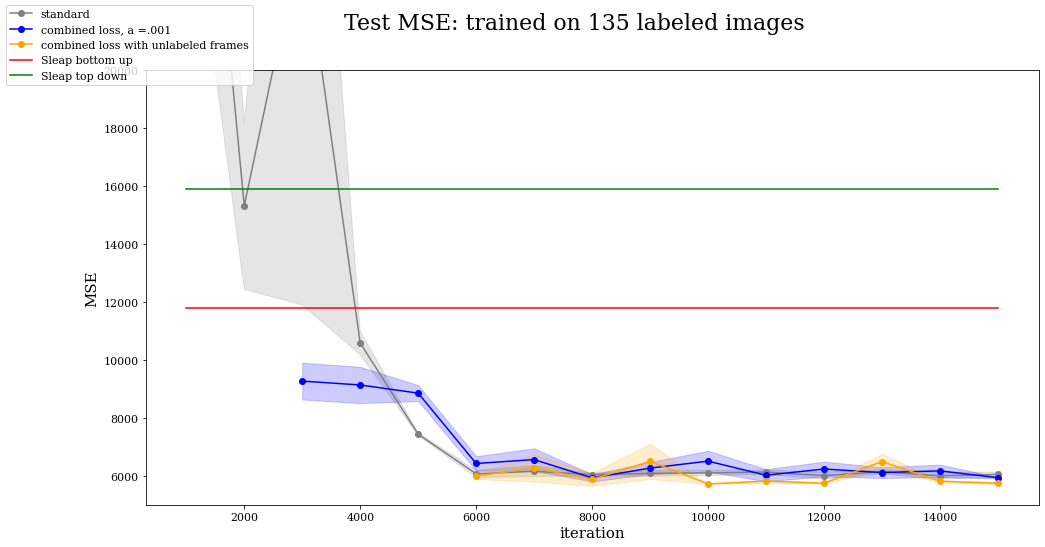

In [354]:
SMALL_SIZE = 11
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rcParams.update({'font.size': 22})
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=40)  # fontsize of the figure title
#plt.rc('font', 8)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


it_c = range(3000,15001,1000)
it1 = range(3000,10001,1000)
itu = range(6000,15001,1000)
ita = range(1000,15001,1000)
fig, axes = plt.subplots(1,1,figsize=(16,8))

plt.xlabel("iteration")
plt.ylabel("MSE")

ax = axes
fig.suptitle("Test MSE: trained on 135 labeled images ",fontsize = 22)
#fig.suptitle('test title', fontsize = 20)
colors = ['r','b','y','g']

plt.plot(ita, sa, '-o', c='grey', label="standard")
plt.fill_between(ita, np.array(sa)-np.array(s_e), np.array(sa)+np.array(s_e),alpha = .2,color='grey')

#plt.plot(it_c, ca, '-o', c='blue', label="combined loss, a =.001")
#plt.fill_between(it_c, np.array(ca)-np.array(c_e), np.array(ca)+np.array(c_e),alpha = .2,color='blue')

plt.plot(it_c, ca, '-o', c='blue', label="combined loss, a =.001")
plt.fill_between(it_c, np.array(ca)-np.array(c_e2), np.array(ca)+np.array(c_e2),alpha = .2,color='blue')

plt.plot(itu, va3, '-o', c='orange', label="combined loss with unlabeled frames")
plt.fill_between(itu, np.array(va3)-np.array(u_e), np.array(va3)+np.array(u_e),alpha = .2,color='orange')

#plt.plot(itu, va3, '-o', c='red', label="combined loss with unlabeled frames")

#plt.plot(itu, ca3, '-o', c='pink', label="beta=.001")
#plt.plot(itu, ca0, '-o', c='red', label="beta=.1")
#plt.plot(itu, ca1, '-o', c='green', label="beta=1")
#plt.plot(itu, b5a, '-o', c='orange', label="beta=.5")
#plt.plot(itu, ca3, '-o', c='pink', label="beta=.001")

plt.plot(ita, bu, c='red', label="Sleap bottom up")
#plt.plot(ypoints, color = 'r')
plt.plot(ita, td, c='green', label="Sleap top down")
ax.set_ylim(top = 20000,bottom = 5000)
fig.legend(loc='upper left')
fig.savefig("all_135" +'.pdf')
plt.show()